In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
print('Using PyTorch version:', torch.__version__, ' Device:', device)

Using PyTorch version: 2.0.0  Device: cuda


In [2]:
batch_size = 32

train_dataset = datasets.MNIST('../data', 
                               train=True, 
                               download=True, 
                               transform=transforms.ToTensor())

validation_dataset = datasets.MNIST('../data', 
                                    train=False, 
                                    transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, 
                                                batch_size=batch_size, 
                                                shuffle=False)

In [3]:
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([32, 1, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


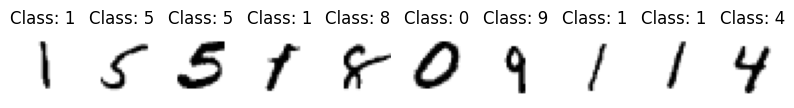

In [6]:
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(X_train[i,:,:,:].numpy().reshape(28,28), cmap="gray_r")
    plt.title('Class: '+str(y_train[i].item()))

In [7]:
# Resize the images to 10x10 pixels
transform = transforms.Compose([
    transforms.Resize((10,10)),
    transforms.ToTensor()])
train_dataset = datasets.MNIST('../data',
                                 train=True,
                                    download=True,
                                    transform=transform)
validation_dataset = datasets.MNIST('../data',
                                    train=False,
                                    transform=transform)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                             batch_size=batch_size,
                                                shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset,
                                                    batch_size=batch_size,
                                                    shuffle=False)

for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([32, 1, 10, 10]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


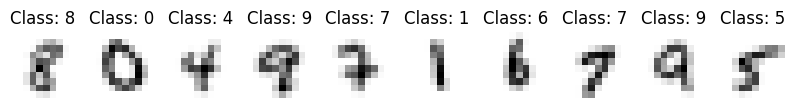

In [15]:
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(X_train[i,:,:,:].numpy().reshape(10,10), cmap="gray_r")
    plt.title('Class: '+str(y_train[i].item()))

In [16]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(10*10, 20)
        self.fc1_drop = nn.Dropout(0.2)
        self.fc2 = nn.Linear(20, 20)
        self.fc2_drop = nn.Dropout(0.2)
        self.fc3 = nn.Linear(20, 10)

    def forward(self, x):
        x = x.view(-1, 10*10)
        x = F.relu(self.fc1(x))
        x = self.fc1_drop(x)
        x = F.relu(self.fc2(x))
        x = self.fc2_drop(x)
        return F.log_softmax(self.fc3(x), dim=1)

model = Net().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
criterion = nn.CrossEntropyLoss()

print(model)

Net(
  (fc1): Linear(in_features=100, out_features=20, bias=True)
  (fc1_drop): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=20, out_features=20, bias=True)
  (fc2_drop): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=20, out_features=10, bias=True)
)


In [17]:
def train(epoch, log_interval=200):
    # Set model to training mode
    model.train()
    
    # Loop over each batch from the training set
    for batch_idx, (data, target) in enumerate(train_loader):
        # Copy data to GPU if needed
        data = data.to(device)
        target = target.to(device)

        # Zero gradient buffers
        optimizer.zero_grad() 
        
        # Pass data through the network
        output = model(data)

        # Calculate loss
        loss = criterion(output, target)

        # Backpropagate
        loss.backward()
        
        # Update weights
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data.item()))

In [18]:
def validate(loss_vector, accuracy_vector):
    model.eval()
    val_loss, correct = 0, 0
    for data, target in validation_loader:
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        val_loss += criterion(output, target).data.item()
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

    val_loss /= len(validation_loader)
    loss_vector.append(val_loss)

    accuracy = 100. * correct.to(torch.float32) / len(validation_loader.dataset)
    accuracy_vector.append(accuracy)
    
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(validation_loader.dataset), accuracy))

In [19]:
%%time
epochs = 20

lossv, accv = [], []
for epoch in range(1, epochs + 1):
    train(epoch)
    validate(lossv, accv)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.299377
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.282162
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.257612
Train Epoch: 1 [19200/60000 (32%)]	Loss: 2.223628
Train Epoch: 1 [25600/60000 (43%)]	Loss: 2.144340
Train Epoch: 1 [32000/60000 (53%)]	Loss: 2.057749
Train Epoch: 1 [38400/60000 (64%)]	Loss: 1.781705
Train Epoch: 1 [44800/60000 (75%)]	Loss: 1.562206
Train Epoch: 1 [51200/60000 (85%)]	Loss: 1.395455
Train Epoch: 1 [57600/60000 (96%)]	Loss: 1.231292

Validation set: Average loss: 1.0861, Accuracy: 6815/10000 (68%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 1.466388
Train Epoch: 2 [6400/60000 (11%)]	Loss: 1.213050
Train Epoch: 2 [12800/60000 (21%)]	Loss: 1.082829
Train Epoch: 2 [19200/60000 (32%)]	Loss: 1.049413
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.912680
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.893024
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.929180
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.697331
Train Epoch: 2 [51200/60000 (85%)]	Loss: 1.01

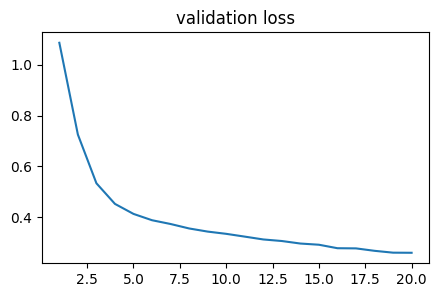

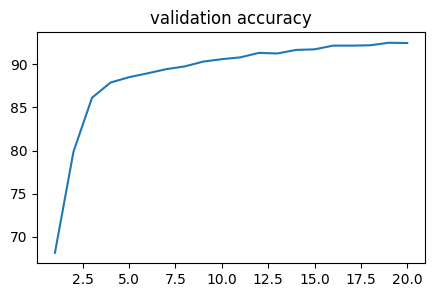

In [20]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), lossv)
plt.title('validation loss')

plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), accv)
plt.title('validation accuracy');

In [21]:
model.state_dict()

OrderedDict([('fc1.weight',
              tensor([[-0.0153,  0.0205,  0.0036,  ..., -0.0428,  0.0381, -0.0357],
                      [-0.0143,  0.0931, -0.0994,  ...,  0.1139, -0.0264, -0.0362],
                      [ 0.0248, -0.0153,  0.0834,  ..., -0.0431, -0.0970,  0.0448],
                      ...,
                      [ 0.0104, -0.0618,  0.0367,  ..., -0.0058, -0.0544, -0.0965],
                      [-0.0245, -0.0032, -0.0830,  ..., -0.1301,  0.0555, -0.0246],
                      [ 0.0824,  0.0845,  0.0866,  ...,  0.2496,  0.0070, -0.0364]],
                     device='cuda:0')),
             ('fc1.bias',
              tensor([-0.3385,  0.0779,  0.3373, -0.0761,  0.2152, -0.0096, -0.0754,  0.1004,
                      -0.2371,  0.0938,  0.5123,  0.5068,  0.0269, -0.1846, -0.0994,  0.1275,
                       0.1754,  0.2971,  0.2567,  0.0275], device='cuda:0')),
             ('fc2.weight',
              tensor([[-2.3640e-01,  4.7029e-01, -2.3011e-01,  1.3321e-01, -3.70

In [22]:
len(model.state_dict()['fc1.weight'])

20

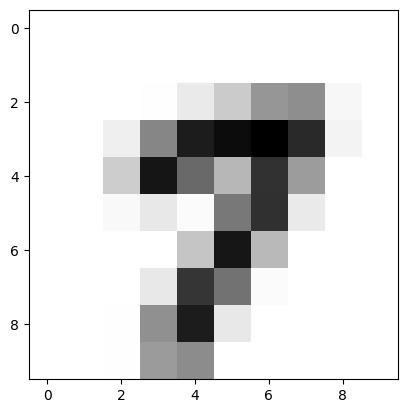

In [35]:
# get the first img
img = X_train[7,:,:,:].numpy().reshape(10,10)
# plot the first img
plt.imshow(img, cmap='gray_r')

In [36]:
flatten = img.reshape(1, 10*10)

In [37]:
model.state_dict()['fc1.weight'].cpu().numpy().dot(flatten.T)

array([[-0.15658745],
       [ 0.39871004],
       [-2.0662124 ],
       [-1.0433314 ],
       [ 0.13240309],
       [-0.1738144 ],
       [-0.06895398],
       [-0.8044269 ],
       [-0.12350547],
       [ 0.92810494],
       [-1.1291963 ],
       [-0.3548504 ],
       [-0.2703941 ],
       [-0.6476583 ],
       [-0.08379395],
       [-0.63181925],
       [ 1.122678  ],
       [ 0.79068947],
       [-0.12218061],
       [ 0.70722914]], dtype=float32)

In [38]:
# Do feedforward
output_fc1 = model.state_dict()['fc1.weight'].cpu().numpy().dot(flatten.T) + model.state_dict()['fc1.bias'].cpu().numpy().reshape(20,1)
print(output_fc1)
output_fc1_relu = np.maximum(output_fc1, 0)

[[-0.49508044]
 [ 0.4765705 ]
 [-1.7288759 ]
 [-1.1194186 ]
 [ 0.34760034]
 [-0.1833775 ]
 [-0.1444022 ]
 [-0.70403135]
 [-0.3606005 ]
 [ 1.0218635 ]
 [-0.6169332 ]
 [ 0.1519525 ]
 [-0.24347278]
 [-0.8322313 ]
 [-0.18319026]
 [-0.50428253]
 [ 1.2980753 ]
 [ 1.0877397 ]
 [ 0.13448107]
 [ 0.7346825 ]]


In [39]:
output_fc2 = model.state_dict()['fc2.weight'].cpu().numpy().dot(output_fc1_relu) + model.state_dict()['fc2.bias'].cpu().numpy().reshape(20,1)
output_fc2_relu = np.maximum(output_fc2, 0)

In [40]:
output_fc3 = model.state_dict()['fc3.weight'].cpu().numpy().dot(output_fc2_relu) + model.state_dict()['fc3.bias'].cpu().numpy().reshape(10,1)
output_fc3

array([[-1.8179607 ],
       [-8.149392  ],
       [ 0.05545306],
       [ 1.6313826 ],
       [-3.237844  ],
       [ 0.5098573 ],
       [-9.313666  ],
       [11.849044  ],
       [-2.2549908 ],
       [ 8.511258  ]], dtype=float32)

In [41]:
# Do log_softmax
output_fc3 = model.state_dict()['fc3.weight'].cpu().numpy().dot(output_fc2_relu) + model.state_dict()['fc3.bias'].cpu().numpy().reshape(10,1)
output_fc3_log_softmax = output_fc3 - np.max(output_fc3)
output_fc3_log_softmax = output_fc3_log_softmax - np.log(np.sum(np.exp(output_fc3_log_softmax), axis=0))
output_fc3_log_softmax

array([[-13.70196   ],
       [-20.033392  ],
       [-11.828546  ],
       [-10.252616  ],
       [-15.121842  ],
       [-11.374142  ],
       [-21.197666  ],
       [ -0.03495548],
       [-14.138989  ],
       [ -3.3727412 ]], dtype=float32)

In [42]:

# Get the prediction
np.argmax(output_fc3_log_softmax)

7

In [30]:
# Export this as a .h file
import os
os.makedirs('../c_app', exist_ok=True)
# Write the .h file
with open('../c_headers/weights.h', 'w') as f:
    # Do this for each layer
    # fc1
    temp = 'const float {}[{}][{}] = '.format('fc1_weights', model.state_dict()['fc1.weight'].shape[0] , model.state_dict()['fc1.weight'].shape[1])
    f.write(temp)
    f.write('{\n')
    for i in range(model.state_dict()['fc1.weight'].shape[0]):
        f.write('{')
        for j in range(model.state_dict()['fc1.weight'].shape[1]):
            # Only 2 floating points
            f.write('{:.6f}'.format(model.state_dict()['fc1.weight'][i][j].item()))
            if j != model.state_dict()['fc1.weight'].shape[1] - 1:
                f.write(', ')
        f.write('}')
        if i != model.state_dict()['fc1.weight'].shape[0] - 1:
            f.write(',\n')
    f.write('\n};\n\n')

    # fc1 bias
    bias_reshape = model.state_dict()['fc1.bias'].cpu().numpy().reshape(20,1)
    temp = 'const float {}[{}][{}] = '.format('fc1_bias', bias_reshape.shape[0], bias_reshape.shape[1])
    f.write(temp)
    f.write('{\n')
    for i in range(bias_reshape.shape[0]):
        f.write('{')
        for j in range(bias_reshape.shape[1]):
            # Only 2 floating points
            f.write('{:.6f}'.format(bias_reshape[i][j]))
            if j != bias_reshape.shape[1] - 1:
                f.write(', ')
        f.write('}')
        if i != bias_reshape.shape[0] - 1:
            f.write(',\n')
    f.write('\n};\n\n')
    
    # fc2 
    temp = 'const float {}[{}][{}] = '.format('fc2_weights', model.state_dict()['fc2.weight'].shape[0] , model.state_dict()['fc2.weight'].shape[1])
    f.write(temp)
    f.write('{\n')
    for i in range(model.state_dict()['fc2.weight'].shape[0]):
        f.write('{')
        for j in range(model.state_dict()['fc2.weight'].shape[1]):
            # Only 2 floating points
            f.write('{:.6f}'.format(model.state_dict()['fc2.weight'][i][j].item()))
            if j != model.state_dict()['fc2.weight'].shape[1] - 1:
                f.write(', ')
        f.write('}')
        if i != model.state_dict()['fc2.weight'].shape[0] - 1:
            f.write(',\n')
    f.write('\n};\n\n')

    # fc2 bias
    bias_reshape = model.state_dict()['fc2.bias'].cpu().numpy().reshape(20,1)
    temp = 'const float {}[{}][{}] = '.format('fc2_bias', bias_reshape.shape[0], bias_reshape.shape[1])
    f.write(temp)
    f.write('{\n')
    for i in range(bias_reshape.shape[0]):
        f.write('{')
        for j in range(bias_reshape.shape[1]):
            # Only 2 floating points
            f.write('{:.6f}'.format(bias_reshape[i][j]))
            if j != bias_reshape.shape[1] - 1:
                f.write(', ')
        f.write('}')
        if i != bias_reshape.shape[0] - 1:
            f.write(',\n')
    f.write('\n};\n\n')

    # fc3
    temp = 'const float {}[{}][{}] = '.format('fc3_weights', model.state_dict()['fc3.weight'].shape[0] , model.state_dict()['fc3.weight'].shape[1])
    f.write(temp)
    f.write('{\n')
    for i in range(model.state_dict()['fc3.weight'].shape[0]):
        f.write('{')
        for j in range(model.state_dict()['fc3.weight'].shape[1]):
            # Only 2 floating points
            f.write('{:.6f}'.format(model.state_dict()['fc3.weight'][i][j].item()))
            if j != model.state_dict()['fc3.weight'].shape[1] - 1:
                f.write(', ')
        f.write('}')
        if i != model.state_dict()['fc3.weight'].shape[0] - 1:
            f.write(',\n')
    f.write('\n};\n\n')

    # fc3 bias
    bias_reshape = model.state_dict()['fc3.bias'].cpu().numpy().reshape(10,1)
    temp = 'const float {}[{}][{}] = '.format('fc3_bias', bias_reshape.shape[0], bias_reshape.shape[1])
    f.write(temp)
    f.write('{\n')
    for i in range(bias_reshape.shape[0]):
        f.write('{')
        for j in range(bias_reshape.shape[1]):
            # Only 2 floating points
            f.write('{:.6f}'.format(bias_reshape[i][j]))
            if j != bias_reshape.shape[1] - 1:
                f.write(', ')
        f.write('}')
        if i != bias_reshape.shape[0] - 1:
            f.write(',\n')
    f.write('\n};\n\n')
    f.close()

In [31]:
# Export this as a .h file

# Write the .h file
with open('../c_headers/weights_2_copy.h', 'w') as f:
    f.write('''#define NUM_LAYERS 3\n
#define SIZE_L0 100\n
#define SIZE_L1 20\n
#define SIZE_L2 20\n
#define SIZE_L3 10\n

const __uint16_t size_layers [NUM_LAYERS + 1] =  {SIZE_L0, SIZE_L1, SIZE_L2, SIZE_L3 };\n

struct layer {\n
   __uint16_t size_input;\n
   __uint16_t size_output;\n
   float* weights;\n
   float* bias;\n
};\n

struct layer fc0;\n
struct layer fc1;\n
struct layer fc2;\n
struct layer fc3; \n''')
    # Do this for each layer
    # fc1
    temp = 'const float {}[{} * {}] = '.format('fc1_weights', model.state_dict()['fc1.weight'].shape[0] , model.state_dict()['fc1.weight'].shape[1])
    f.write(temp)
    f.write('{\n')
    for i in range(model.state_dict()['fc1.weight'].shape[0]):
     
        for j in range(model.state_dict()['fc1.weight'].shape[1]):
            # Only 2 floating points
            f.write('{:.6f}'.format(model.state_dict()['fc1.weight'][i][j].item()))
            if j != model.state_dict()['fc1.weight'].shape[1] - 1:
                f.write(', ')
        
        if i != model.state_dict()['fc1.weight'].shape[0] - 1:
            f.write(',\n')
    f.write('\n};\n\n')

    # fc1 bias
    bias_reshape = model.state_dict()['fc1.bias'].cpu().numpy().reshape(20,1)
    temp = 'const float {}[{} * {}] = '.format('fc1_bias', bias_reshape.shape[0], bias_reshape.shape[1])
    f.write(temp)
    f.write('{\n')
    for i in range(bias_reshape.shape[0]):
       
        for j in range(bias_reshape.shape[1]):
            # Only 2 floating points
            f.write('{:.6f}'.format(bias_reshape[i][j]))
            if j != bias_reshape.shape[1] - 1:
                f.write(', ')
       
        if i != bias_reshape.shape[0] - 1:
            f.write(',\n')
    f.write('\n};\n\n')
    
    # fc2 
    temp = 'const float {}[{} * {}] = '.format('fc2_weights', model.state_dict()['fc2.weight'].shape[0] , model.state_dict()['fc2.weight'].shape[1])
    f.write(temp)
    f.write('{\n')
    for i in range(model.state_dict()['fc2.weight'].shape[0]):
       
        for j in range(model.state_dict()['fc2.weight'].shape[1]):
            # Only 2 floating points
            f.write('{:.6f}'.format(model.state_dict()['fc2.weight'][i][j].item()))
            if j != model.state_dict()['fc2.weight'].shape[1] - 1:
                f.write(', ')
  
        if i != model.state_dict()['fc2.weight'].shape[0] - 1:
            f.write(',\n')
    f.write('\n};\n\n')

    # fc2 bias
    bias_reshape = model.state_dict()['fc2.bias'].cpu().numpy().reshape(20,1)
    temp = 'const float {}[{} * {}] = '.format('fc2_bias', bias_reshape.shape[0], bias_reshape.shape[1])
    f.write(temp)
    f.write('{\n')
    for i in range(bias_reshape.shape[0]):
        
        for j in range(bias_reshape.shape[1]):
            # Only 2 floating points
            f.write('{:.6f}'.format(bias_reshape[i][j]))
            if j != bias_reshape.shape[1] - 1:
                f.write(', ')

        if i != bias_reshape.shape[0] - 1:
            f.write(',\n')
    f.write('\n};\n\n')

    # fc3
    temp = 'const float {}[{} * {}] = '.format('fc3_weights', model.state_dict()['fc3.weight'].shape[0] , model.state_dict()['fc3.weight'].shape[1])
    f.write(temp)
    f.write('{\n')
    for i in range(model.state_dict()['fc3.weight'].shape[0]):
        
        for j in range(model.state_dict()['fc3.weight'].shape[1]):
            # Only 2 floating points
            f.write('{:.6f}'.format(model.state_dict()['fc3.weight'][i][j].item()))
            if j != model.state_dict()['fc3.weight'].shape[1] - 1:
                f.write(', ')
        
        if i != model.state_dict()['fc3.weight'].shape[0] - 1:
            f.write(',\n')
    f.write('\n};\n\n')

    # fc3 bias
    bias_reshape = model.state_dict()['fc3.bias'].cpu().numpy().reshape(10,1)
    temp = 'const float {}[{} * {}] = '.format('fc3_bias', bias_reshape.shape[0], bias_reshape.shape[1])
    f.write(temp)
    f.write('{\n')
    for i in range(bias_reshape.shape[0]):
        
        for j in range(bias_reshape.shape[1]):
            # Only 2 floating points
            f.write('{:.6f}'.format(bias_reshape[i][j]))
            if j != bias_reshape.shape[1] - 1:
                f.write(', ')
        
        if i != bias_reshape.shape[0] - 1:
            f.write(',\n')
    f.write('\n};\n\n')
    f.close()

In [43]:
flatten = flatten.T

In [12]:
# Export the flatten img as a .h file
with open('../c_app/flatten_2_img.h', 'w') as f:
    temp = 'const float {}[{}][{}] = '.format('flatten_img', flatten.shape[0], flatten.shape[1])
    f.write(temp)
    f.write('{\n')
    for i in range(flatten.shape[0]):
        f.write('{')
        for j in range(flatten.shape[1]):
            # Only 2 floating points
            f.write('{:.2f}'.format(flatten[i][j]))
            if j != flatten.shape[1] - 1:
                f.write(', ')
        f.write('}')
        if i != flatten.shape[0] - 1:
            f.write(',\n')
    f.write('\n};\n\n')
    f.close()

In [44]:
with open('../c_app/flatten_2_img_copy.h', 'w') as f:
    temp = 'const float {}[{}] = '.format('flatten_img', flatten.shape[0] * flatten.shape[1])
    f.write(temp)
    f.write('{\n')
    for i in range(flatten.shape[0]):
       
        for j in range(flatten.shape[1]):
            # Only 2 floating points
            f.write('{:.2f}'.format(flatten[i][j]))
            if j != flatten.shape[1] - 1:
                f.write(', ')
        if i != flatten.shape[0] - 1:
            f.write(',\n')
    f.write('\n};\n\n')
    f.close()